# 1. 사전 세팅

In [ ]:
import warnings
warnings.filterwarnings('ignore')

%cd "/content/drive/MyDrive/데이터 분석/projects/ML_portfolio/10_kleague_final_pass_prediction"

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 2. 문제 정의

---

    현대 축구에서 승패는 개별 선수의 기량을 넘어, 유기적인 팀 패턴을 만드는 능력에서 갈린다.
    
    K리그 경기에서의 인사이트는 해당 시점의 선수 배치, 상대 압박, 공격의 전개 방향 등
    복합적인 맥락 속에서 ‘왜 그 공간으로 패스하는 것이 최적이었는가’를 이해하는 데서 나온다.

    특정 상황의 맥락을 AI가 학습하고, 이어지는 패스가 도달할 최적의 위치를 예측하고자 한다.

---

    본 프로젝트는 DACON과 함께합니다.

- [상세 설명](https://dacon.io/competitions/official/236647/overview/description)

## 2.1 도메인 지식



---

▸ 이벤트 좌표 사전 처리

    패스 방향은 항상 상대 공격 방향에 의해 정해지는데, 데이터는 이미 L->R 공격 방향으로 통일
    후반전에 공격 방향 반전되는 문제도 해결

▸ 풀백(포지션)

    축구 포지션 중에서 가장 패스 패턴이 뚜렷하게 나타나는 포지션
    측면(사이드 라인 근처)에 위치하고, 수비 + 공격 전개 둘 다 담당하는 포지션으로, 공간을 넓게 씀

▸ 패스의 4가지 의도

    1. 전진 패스(Progressive Pass): 상대 진영으로 전진해서 공격을 가속하기 위해
    2. 측면 전개(Switching / Wide Pass): 수비 압박을 벗어나기 위해
    3. 후방 안정화 패스(Safety / Reset): 볼 소유를 유지하고 다시 빌드업을 시작하기 위해
    4. 라인 침투 패스(Line Break Pass): 상대 수비 라인을 끊기 위해
    
    여기서 라인 침투 패스가 가장 가치가 높은 패스 !
    결국 패스를 예측하는 것은 위 4가지 중 어디에 속하는지를 모델이 판단하는 것과 같을 수 있음

▸ 패스 예측에서 중요한 특징들

| 유형    | 의미                          | 모델 영향         |
| ----- | --------------------------- | ------------- |
| 공간 정보 | start_x, start_y, 이전 이벤트 좌표 | 패스 방향성을 추론  |
| 압박 정보 | 주변에 상대 수비수가 있는가?            | 패스 거리/각도를 결정  |
| 경기 상황 | 점유 여부, 직전 이벤트 종류            | 패스의 의도를 추론      |

## 2.2 모델 선정

---

▸ Transformer Encoder

    위치 정보(sin positional encoding)가 좌표 시퀀스와 잘 맞고,
    long-range dependency가 LSTM보다 강함

    self-attention이 "어떤 이벤트가 패스 목적지 결정의 핵심인지" 자동으로 학습

    events → embedding → Transformer Encoder → MLP → (end_x, end_y)

▸ BiLSTM (입력 길이가 짧을 때 가장 안정적)

    학습이 Transformer보다 안정적이며 데이터 요구량이 낮음

▸ TCN (Temporal Convolutional Network)

    매우 빠르고, 좌표 이동 패턴을 convolution으로 잘 포착

# 3. 데이터 명세

## 3.1 DataFrame으로 명세 살펴보기

In [ ]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

file_path = "Data/data_description.xlsx"

xls = pd.ExcelFile(file_path)
print("시트 목록:", xls.sheet_names)

sheet_names = xls.sheet_names

dfs = {}

for sheet in sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet)
    dfs[sheet] = df

### 3.1.1 match_info.csv 컬럼 정보

In [ ]:
dfs["컬럼 정의서 (Column Specs)"].iloc[:17]

### 3.1.2 train.csv, test.csv 컬럼 정보

In [ ]:
dfs["컬럼 정의서 (Column Specs)"].iloc[17:]

### 3.1.3 이벤트 타입 시트

In [ ]:
dfs["이벤트 타입 (Event Types)"]

## 3.2 match_info.csv



---

| column_name       | description           | data_type      | notes           |
| ----------------- | --------------------- | -------------- | --------------- |
| game_id           | 경기를 구분하는 고유 ID        | object         |                 |
| season_id         | 시즌 고유 ID              | object         | e.g., 2024시즌    |
| competition_id    | 대회 고유 ID              | object         | e.g., K리그1, FA컵 |
| game_day          | 리그 경기일 (e.g., 1R, 2R) | int64          | 'N라운드' 정보       |
| game_date         | 실제 경기 날짜              | datetime64[ns] |                 |
| home_team_id      | 홈 팀의 고유 ID            | object         |                 |
| away_team_id      | 어웨이 팀의 고유 ID          | object         |                 |
| home_score        | 홈 팀 득점                | int64          |                 |
| away_score        | 어웨이 팀 득점              | int64          |                 |
| venue             | 경기장 이름                | object         |                 |
| competition_name  | 대회 이름 (영문)            | object         |                 |
| country_name      | 리그 국가 이름              | object         |                 |
| season_name       | 시즌 이름                 | object         | e.g., '2024'    |
| home_team_name    | 홈 팀 이름 (영문)           | object         |                 |
| home_team_name_ko | 홈 팀 이름 (한글)           | object         |                 |
| away_team_name    | 어웨이 팀 이름 (영문)         | object         |                 |
| away_team_name_ko | 어웨이 팀 이름 (한글)         | object         |                 |

## 3.3 train / test.csv

---

| column_name  | description                       | data_type | notes                  |
| ------------ | --------------------------------- | --------- | ---------------------- |
| game_id      | 경기를 구분하는 고유 ID                    | int64     |                        |
| period_id    | 전/후반 구분 (1: 전반, 2: 후반…)           | int64     | 1부터 시작                 |
| episode_id   | 공이 라인 밖으로 나가기 전까지의 플레이 단위         | int64     | 1부터 시작                 |
| time_seconds | Period 시작 후 경과 시간(초)              | float64   | action_id와 순서 불일치 가능   |
| team_id      | 이벤트 수행 팀 ID                       | int64     |                        |
| player_id    | 이벤트 수행 선수 ID                      | float64   | 동시간대 이벤트 시 순서 뒤섞일 수 있음 |
| action_id    | 경기 내 이벤트 순서                       | int64     | 0부터 시작, 일부 이벤트 삭제됨     |
| type_name    | 이벤트 종류                            | object    | 이벤트 타입 표 참고            |
| result_name  | 이벤트 성공/실패 상태                      | object    | 이벤트 타입 표 참고            |
| start_x      | 이벤트 시작 X좌표                        | float64   | L→R 기준 좌표              |
| start_y      | 이벤트 시작 Y좌표                        | float64   | L→R 기준 좌표              |
| end_x        | 이벤트 종료 X좌표                        | float64   | L→R 기준 좌표              |
| end_y        | 이벤트 종료 Y좌표                        | float64   | L→R 기준 좌표              |
| is_home      | 홈 팀 여부                            | bool      |                        |
| game_episode | `{game_id}_{episode_id}` 고유 그룹 ID | object    |                        |

## 3.4 이벤트 타입(type_name)

---

| type_name        | result_name        | Description       | notes |
| ---------------- | ------------------ | ----------------- | ----- |
| Aerial Clearance | Successful         | 골키퍼 공중볼 처리 성공     |       |
| Aerial Clearance | Unsuccessful       | 공중볼 처리 실패         |       |
| Block            | NaN                | 상대 패스·크로스·슛 차단    |       |
| Carry            | NaN                | 공을 몰고 이동          |       |
| Catch            | NaN                | 골키퍼가 공을 캐치        |       |
| Clearance        | NaN                | 의도 없이 멀리 걷어낸 수비   |       |
| Cross            | Unsuccessful       | 크로스 실패            |       |
| Cross            | Successful         | 크로스 성공            |       |
| Deflection       | NaN                | 슛이 선수 몸에 맞아 방향 변함 |       |
| Duel             | Successful         | 경합 승리             |       |
| Duel             | Unsuccessful       | 경합 패배             |       |
| Error            | NaN                | 압박 없는 상황의 실수      |       |
| Foul             | NaN                | 파울(카드 없음)         |       |
| Foul             | Yellow_Card        | 옐로 카드 파울          |       |
| Foul             | Direct_Red_Card    | 다이렉트 레드           |       |
| Foul             | Second_Yellow_Card | 옐로 누적 레드          |       |
| Foul_Throw       | NaN                | 스로인 반칙            |       |
| Goal             | NaN                | 득점                |       |
| Goal Kick        | Successful         | 골킥 성공             |       |
| Goal Kick        | Unsuccessful       | 골킥 실패             |       |
| Handball_Foul    | NaN                | 핸드볼 파울            |       |
| Handball_Foul    | Yellow_Card        | 핸드볼 옐로카드          |       |
| Handball_Foul    | Second_Yellow_Card | 핸드볼 누적 레드         |       |
| Handball_Foul    | Direct_Red_Card    | 의도적 핸드볼 레드        |       |
| Hit              | NaN                | 의도치 않은 공 맞음       |       |
| Interception     | NaN                | 패스 경로 차단 후 소유권 획득 |       |
| Intervention     | NaN                | 소유권 방해(획득 X)      |       |
| Offside          | NaN                | 오프사이드             |       |
| Out              | NaN                | 공 아웃              |       |
| Own Goal         | NaN                | 자책골               |       |
| Parry            | NaN                | GK가 공을 쳐내기만 함     |       |
| Pass             | Successful         | 패스 성공             |       |
| Pass             | Unsuccessful       | 패스 실패             |       |
| Pass_Corner      | Unsuccessful       | 코너킥 패스 실패         |       |
| Pass_Corner      | Successful         | 코너킥 패스 성공         |       |
| Pass_Freekick    | Successful         | 프리킥 패스 성공         |       |
| Pass_Freekick    | Unsuccessful       | 프리킥 패스 실패         |       |
| Penalty Kick     | Goal               | PK 득점             |       |
| Penalty Kick     | On Target          | PK 유효슛, GK 방어     |       |
| Penalty Kick     | Off Target         | PK 빗나감            |       |
| Penalty Kick     | NaN                |                   |       |
| Recovery         | NaN                | 루즈볼 재획득           |       |
| Shot             | Off Target         | 골문 벗어난 슛          |       |
| Shot             | On Target          | 유효슈팅              |       |
| Shot             | Blocked            | 블록당함              |       |
| Shot             | Goal               | 슛 득점              |       |
| Shot             | Low Quality Shot   | 품질 낮은 슛           |       |
| Shot             | Keeper Rush-Out    | GK 돌출 상황 슛        |       |
| Shot             | NaN                |                   |       |
| Shot_Corner      | Goal               | 코너킥 직접 득점         |       |
| Shot_Freekick    | Off Target         | 프리킥 슛 빗나감         |       |
| Shot_Freekick    | Blocked            | 프리킥 블록            |       |
| Shot_Freekick    | On Target          | 프리킥 유효슛           |       |
| Shot_Freekick    | Goal               | 프리킥 득점            |       |
| Shot_Freekick    | Low Quality Shot   | 품질 낮은 프리킥 슛       |       |
| Tackle           | Unsuccessful       | 태클 실패             |       |
| Tackle           | Successful         | 태클 성공             |       |
| Take-On          | Unsuccessful       | 드리블 돌파 실패         |       |
| Take-On          | Successful         | 드리블 돌파 성공         |       |
| Throw-In         | Successful         | 스로인 성공            |       |
| Throw-In         | Unsuccessful       | 스로인 실패            |       |
| Throw-In         | NaN                |                   |       |

# 4. 데이터 살펴보기

## 4.1 match_info.csv

In [ ]:
file_path = 'Data/match_info.csv'

match_info = pd.read_csv(file_path)
match_info.head()

In [ ]:
match_info.info()



```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   game_id            228 non-null    int64
 1   season_id          228 non-null    int64
 2   competition_id     228 non-null    int64
 3   game_day           228 non-null    int64
 4   game_date          228 non-null    object
 5   home_team_id       228 non-null    int64
 6   away_team_id       228 non-null    int64
 7   home_score         228 non-null    int64
 8   away_score         228 non-null    int64
 9   venue              228 non-null    object
 10  competition_name   228 non-null    object
 11  country_name       228 non-null    object
 12  season_name        228 non-null    int64
 13  home_team_name     228 non-null    object
 14  home_team_name_ko  228 non-null    object
 15  away_team_name     228 non-null    object
 16  away_team_name_ko  228 non-null    object
dtypes: int64(9), object(8)
memory usage: 30.4+ KB
```



## 4.2 train.csv

In [ ]:
train_df = pd.read_csv('Data/train.csv')
train_df.info()



```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356721 entries, 0 to 356720
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   game_id       356721 non-null  int64  
 1   period_id     356721 non-null  int64  
 2   episode_id    356721 non-null  int64  
 3   time_seconds  356721 non-null  float64
 4   team_id       356721 non-null  int64  
 5   player_id     356721 non-null  int64  
 6   action_id     356721 non-null  int64  
 7   type_name     356721 non-null  object
 8   result_name   216467 non-null  object
 9   start_x       356721 non-null  float64
 10  start_y       356721 non-null  float64
 11  end_x         356721 non-null  float64
 12  end_y         356721 non-null  float64
 13  is_home       356721 non-null  bool   
 14  game_episode  356721 non-null  object
dtypes: bool(1), float64(5), int64(6), object(3)
memory usage: 38.4+ MB
```



In [ ]:
train_df.tail()

In [ ]:
last_events = (train_df.groupby('game_episode').tail(1))

not_pass_df = last_events[last_events['type_name'] != 'Pass']

print("총 에피소드 수 :", len(last_events))
print("마지막 이벤트가 Pass가 아닌 에피소드:", len(not_pass_df))
# display(not_pass_df.head())

    train도 검증
    
    총 에피소드 수 : 15435
    마지막 이벤트가 Pass가 아닌 에피소드: 0

In [ ]:
suc_pass_df = last_events[last_events['result_name'] == 'Successful']

print("패스에 성공한 에피소드 수 :", len(suc_pass_df))
print("패스에 실패한 에피소드 수 :", len(last_events) - len(suc_pass_df))

    패스에 성공한 에피소드 수 : 8634
    패스에 실패한 에피소드 수 : 6801

## 4.3 test.csv

In [ ]:
test_df = pd.read_csv('Data/test.csv')
test_df.info()



```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2414 entries, 0 to 2413
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   game_id       2414 non-null   int64
 1   game_episode  2414 non-null   object
 2   path          2414 non-null   object
dtypes: int64(1), object(2)
memory usage: 56.7+ KB
```



In [ ]:
test_df.head()

In [ ]:
# 내부 파일(path)를 따라 하나만 출력해보자
path = 'Data' + test_df.iloc[0]['path'][1:]

epi1_test_df = pd.read_csv(path)

# 예측해야할 것 = 최종 좌표
print(epi1_test_df.iloc[-1]['end_x'], epi1_test_df.iloc[-1]['end_y'])

In [ ]:
epi1_test_df.tail(1)

    그렇다면, 최종 좌표들이 모두 '패스' 좌표인가 ??! 검증해보자.

In [ ]:
from tqdm import tqdm

not_pass_list = []

for path in tqdm(test_df['path'], desc="Checking episodes"):
    full_path = 'Data' + path[1:]
    epi_df = pd.read_csv(full_path)

    if epi_df.iloc[-1]['type_name'] != 'Pass':
        not_pass_list.append(full_path)

not_pass_list

    검증 결과,

    Checking episodes: 100%|██████████| 2414/2414 [05:31<00:00,  7.29it/s]
    [] -> 빈 리스트라면, 모두 Pass라는 뜻

    최종 이벤트는 모두 패스인 것을 확인


In [ ]:
suc_pass_list = []

for path in tqdm(test_df['path'], desc="Checking episodes"):
    full_path = 'Data' + path[1:]
    epi_df = pd.read_csv(full_path)

    if epi_df.iloc[-1]['result_name'] == 'Successful':
        suc_pass_list.append(full_path)

In [ ]:
print(f'성공한 최종 패스: {len(suc_pass_list)}개, 실패한 최종 패스: {len(test_df)-len(suc_pass_list)}개')

    성공한 최종 패스: 1317개, 실패한 최종 패스: 1097개

    결국 예측해야할 것은 에피소드별 최종 'Pass' 좌표 !
    다른 이벤트들의 좌표들은 주어져있기 때문에,
    최종 좌표, 그 이전의 어떤 좌표와 맥락을 띠고 있었는지를 함께 담아주는 seq-to-regression 모델을 선정해야할 것 같음

    예를 들어 간단하게 BiLSTM, Transformer 구조로 baseline을 잡아야 할 듯 !

# 5. 문제 해결 프로세스 정의

---

▸ 문제
  
    1. As-Is
    기존 분석은 단편적인 이벤트 기록에 그쳐 전술적 의도 해석이 어렵다.

    2. To-Be
    Episode를 기반으로 AI가 플레이 맥락을 학습하는 구조를 구축한다.

    3. Goal
    주어진 시퀀스(episode)의 마지막 패스 좌표(end_x, end_y)를 예측

▸ 기대 효과

    전술 분석 자동화 및 선수/팀 평가 고도화
    데이터 기반 경기 해석 능력 향상

▸ 해결 방안

    시퀀스 중심의 Transformer/LSTM 기반 모델 적용
    Δx/Δy, 패스 각도, zone 등 도메인 기반 feature engineering
    train/test episode reconstruction 및 통합 전처리 파이프라인 만들기

▸ 성과 측정

    MAE/RMSE 기반 좌표 예측 정확도 평가
    zone 단위 tactical accuracy 분석
    episode length별 성능 비교

    결과적으로 유클리드 거리(Euclidean Distance)를 이용한 평가 진행


# 6. Data Readiness Check

## 6.1 기본적인 확인

In [ ]:
train_df = pd.read_csv('Data/train.csv')
train_df.shape



```
(356721, 15)
```



In [ ]:
train_df.describe().T.round(2)


    x 좌표들이 0~105 범위 내 존재, y 좌표들도 0~68 범위 내 존재하는 것 확인

## 6.2 에피소드 단위 개수나 분포 확인

In [ ]:
epi_length = train_df.groupby('game_episode').size()
epi_length.describe()

    270개의 에피소드는 조금 확인해볼 필요가 있을 것 같음..!!

In [ ]:
import matplotlib.pyplot as plt

epi_length.plot.hist(bins=50)
plt.show()

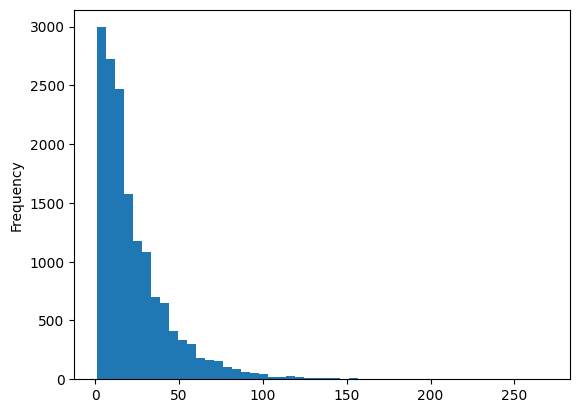

In [ ]:
long_episodes = epi_length.sort_values(ascending=False).head(10)

print(long_episodes)

    이렇게 살펴보니 270개가 말이 될 수도 있겠다 싶네... 그래도 한 번은 세부적으로 살펴보게따

```
game_episode
126408_54    270
126352_15    222
126321_9     220
126333_6     197
126469_30    191
126286_11    182
126351_24    177
126477_43    174
126304_42    173
126371_66    168
dtype: int64
```



In [ ]:
ep_id = epi_length.idxmax()
ep_len = epi_length.max()

print("가장 긴 episode:", ep_id, "길이:", ep_len)

ep = train_df[train_df["game_episode"] == ep_id].sort_values("time_seconds")



```
가장 긴 episode: 126408_54 길이: 270
```



## 6.3 에피소드 시각화

In [ ]:
import matplotlib.patches as patches

EVENT_COLORS = {
    "Pass": "#1f77b4",
    "Carry": "#ff7f0e",
    "Interception": "#2ca02c",
    "Tackle": "#d62728",
    "Shot": "#9467bd",
    "Out": "#8c564b",
    "Duel": "#e377c2",
    "Clearance": "#7f7f7f",
    "Recovery": "#bcbd22",
    "Block": "#17becf",
}

TEAM_COLORS = {
    True: "#1f77b4",
    False: "#d62728"
}

def get_event_color(event):
    return EVENT_COLORS[event] if event in EVENT_COLORS else "#444444"

def draw_pitch(ax):
    ax.add_patch(patches.Rectangle((0, 0), 105, 68,
                                   edgecolor="black", facecolor="#efefef", lw=2))
    ax.plot([52.5, 52.5], [0, 68], color="black", lw=2)
    ax.add_patch(patches.Circle((52.5, 34), 9.15,
                                edgecolor="black", facecolor="none", lw=2))
    ax.add_patch(patches.Rectangle((0, 13.84), 16.5, 40.32,
                                   edgecolor="black", facecolor="none", lw=2))
    ax.add_patch(patches.Rectangle((105-16.5, 13.84), 16.5, 40.32,
                                   edgecolor="black", facecolor="none", lw=2))
    ax.set_xlim(0, 105)
    ax.set_ylim(0, 68)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])

def visualize_episode(ep):
    fig, ax = plt.subplots(figsize=(12, 8))
    draw_pitch(ax)

    g_id = ep["game_id"].iloc[0]
    p_id = ep["period_id"].iloc[0]
    e_id = ep["episode_id"].iloc[0]
    plt.title(f"Game {g_id} | Period {p_id} | Episode {e_id}", fontsize=18)

    ep = ep.reset_index(drop=True)
    for idx, row in ep.iterrows():
        sx, sy = row["start_x"], row["start_y"]
        ex, ey = row["end_x"], row["end_y"]
        color = get_event_color(row["type_name"])

        ax.scatter(sx, sy, color=color, s=80, zorder=3)
        ax.text(sx, sy + 1.2, str(idx), fontsize=9, color="black")
        ax.text(sx, sy - 1.5, row["type_name"], fontsize=7, color=color)

        if not np.isnan(ex) and not np.isnan(ey):
            ax.annotate("", xy=(ex, ey), xytext=(sx, sy),
                        arrowprops=dict(arrowstyle="->", lw=1.4, color=color))

    handles = [patches.Patch(color=v, label=k) for k, v in EVENT_COLORS.items()]
    plt.legend(handles=handles, fontsize=8, loc="upper right")
    plt.show()

def visualize_episode_team(ep):
    fig, ax = plt.subplots(figsize=(12, 8))
    draw_pitch(ax)

    g_id = ep["game_id"].iloc[0]
    p_id = ep["period_id"].iloc[0]
    e_id = ep["episode_id"].iloc[0]
    plt.title(f"[Team View] Game {g_id} | Period {p_id} | Episode {e_id}", fontsize=18)

    ep = ep.reset_index(drop=True)
    for idx, row in ep.iterrows():
        sx, sy = row["start_x"], row["start_y"]
        ex, ey = row["end_x"], row["end_y"]
        tcolor = TEAM_COLORS[row["is_home"]]

        ax.scatter(sx, sy, color=tcolor, s=90, zorder=3)
        ax.text(sx, sy + 1.2, str(idx), fontsize=9, color="black")

        if not np.isnan(ex) and not np.isnan(ey):
            ax.annotate("", xy=(ex, ey), xytext=(sx, sy),
                        arrowprops=dict(arrowstyle="->", lw=1.6, color=tcolor))

    handles = [
        patches.Patch(color=TEAM_COLORS[True], label="Home Team"),
        patches.Patch(color=TEAM_COLORS[False], label="Away Team")
    ]
    plt.legend(handles=handles, fontsize=10, loc="upper right")
    plt.show()

In [ ]:
ep = train_df[train_df["game_episode"] == "126408_54"].reset_index(drop=True)

visualize_episode_team(ep)
visualize_episode(ep)

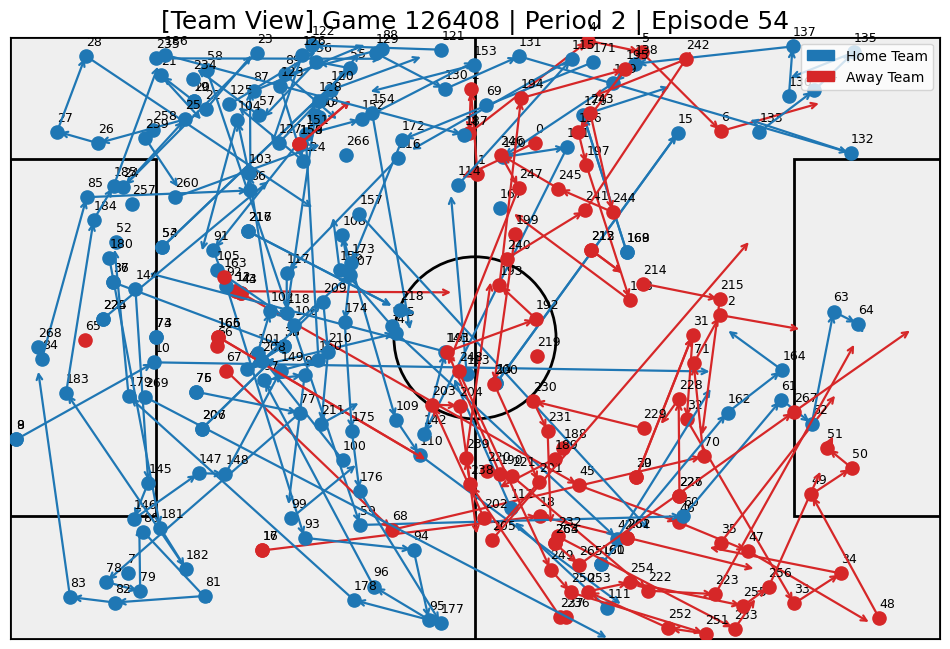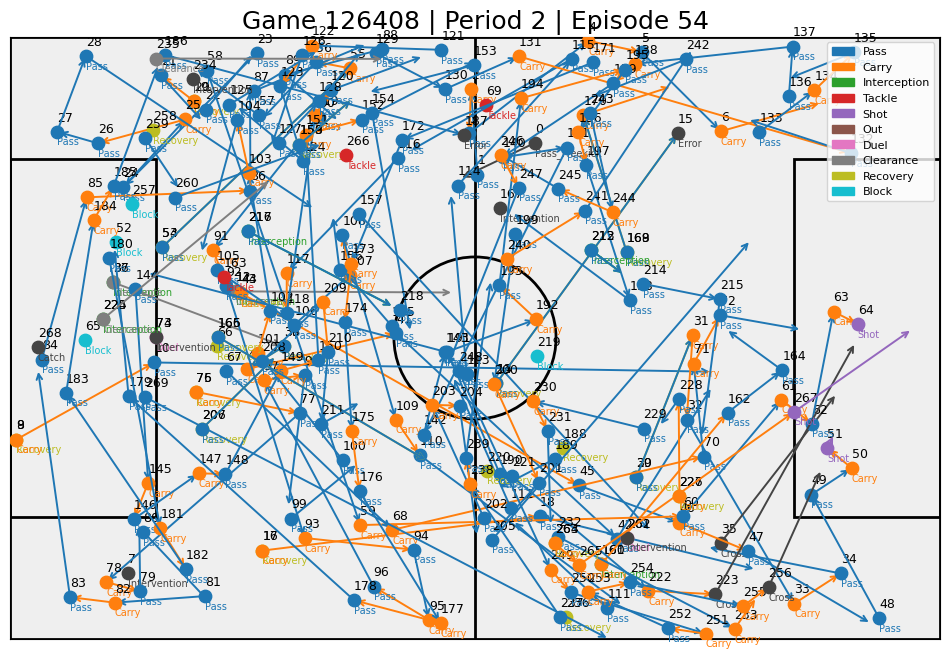

In [ ]:
ep = train_df[train_df["game_episode"] == "126399_58"].reset_index(drop=True)

visualize_episode_team(ep)
visualize_episode(ep)

## 6.4 에피소드 내부 이벤트들 정렬 구조 Check

---

    모델에는 결국 [(이벤트1), (이벤트2), ..., (이벤트N)] 이런 식으로 입력되기 때문에,
    시간 순서(time_seconds)나, 동일 시간 내 발생 순서(action_id)가 정합적인지를 검증해야 함

In [ ]:
key_cols = ['game_id', 'period_id', 'episode_id', 'time_seconds', 'action_id']

def find_disordered_episodes(df):
    bad_episodes = []
    bad_pairs = []

    for ge, g in df.groupby('game_episode'):
        t = g['time_seconds'].values
        a = g['action_id'].values
        idx = g.index.values

        for i in range(len(g) - 1):
            # (t[i], a[i]) > (t[i+1], a[i+1]) 인 경우
            if t[i] > t[i+1] or (t[i] == t[i+1] and a[i] > a[i+1]):
                bad_episodes.append(ge)
                bad_pairs.append({
                    "game_episode": ge,
                    "idx_prev": int(idx[i]),
                    "idx_next": int(idx[i+1]),
                    "t_prev": float(t[i]),
                    "a_prev": int(a[i]),
                    "t_next": float(t[i+1]),
                    "a_next": int(a[i+1]),
                })
                break

    return bad_episodes, bad_pairs

bad_episodes, bad_pairs = find_disordered_episodes(train_df)

len_all = train_df['game_episode'].nunique()
len_bad = len(bad_episodes)

print(f"전체 episode 수: {len_all}")
print(f"정렬 문제 있는 episode 수: {len_bad} ({len_bad/len_all*100:.2f}%)")



```
전체 episode 수: 15435
정렬 문제 있는 episode 수: 286 (1.85%)
```

    약 98% 이상 episode는 정렬 깔끔 !!


In [ ]:
dt_list = []

for ge, g in train_df.groupby('game_episode'):
    t = g['time_seconds'].values

    for i in range(len(t)-1):
        dt = t[i+1] - t[i]
        if dt < 0:
            dt_list.append(dt)

dt_series = pd.Series(dt_list)

print("총 역전(dt < 0) 발생 건수:", len(dt_series))
print(dt_series.describe())

small_rev = dt_series[(dt_series >= -0.1) & (dt_series < 0)]
big_rev = dt_series[dt_series < -0.1]

print("\n작은 역전(미세 부동소수 오차) 비율:")
print(f"{len(small_rev)} / {len(dt_series)} = {len(small_rev)/len(dt_series)*100:.2f}%")

print("\n큰 역전(실제 순서 파괴) 비율:")
print(f"{len(big_rev)} / {len(dt_series)} = {len(big_rev)/len(dt_series)*100:.2f}%")

plt.hist(dt_series, bins=50, edgecolor='black')
plt.title("Distribution of Negative Time Deltas (dt < 0)")
plt.xlabel("dt (seconds)")
plt.ylabel("count")
plt.show()



```
총 역전(dt < 0) 발생 건수: 297
count    297.000000
mean      -0.176943
std        0.450166
min       -3.732000
25%       -0.100000
50%       -0.066000
75%       -0.033000
max       -0.001000
dtype: float64

작은 역전(미세 부동소수 오차) 비율:
215 / 297 = 72.39%

큰 역전(실제 순서 파괴) 비율:
82 / 297 = 27.61%
```



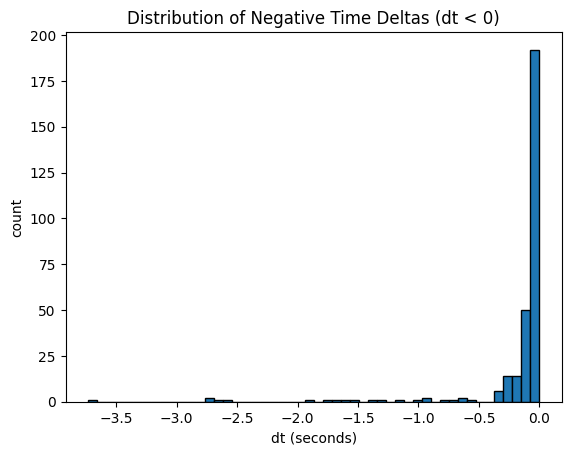

## 6.5 이벤트 세부 분석

In [ ]:
event_col = "type_name"

event_counts = train_df[event_col].value_counts()
event_ratios = train_df[event_col].value_counts(normalize=True)

print("\nPass ratio: {:.2f}%".format(event_ratios.get("Pass", 0) * 100))

print("\n===== Event Type Ratio =====")
print(event_ratios)



```
Pass ratio: 50.06%

===== Event Type Ratio =====
type_name
Pass                0.500621
Carry               0.230000
Recovery            0.076676
Interception        0.031083
Duel                0.024484
Tackle              0.022813
Throw-In            0.019065
Clearance           0.018398
Intervention        0.016926
Block               0.011166
Pass_Freekick       0.010720
Cross               0.010061
Goal Kick           0.007605
Error               0.004617
Shot                0.003961
Pass_Corner         0.003187
Catch               0.002857
Take-On             0.002767
Aerial Clearance    0.001340
Parry               0.001046
Hit                 0.000364
Shot_Freekick       0.000121
Foul                0.000073
Deflection          0.000039
Penalty Kick        0.000006
Handball_Foul       0.000003
Name: proportion, dtype: float64
```



    K 리그의 경기 전개에서 Carry 기반 빌드업이 상당히 자주 발생한다.

    그리고, Recovery ≈ 7.7% + Interception ≈ 3.1% + Tackle/Duel ≈ 4~5%으로
    약 15%가 ‘공 소유권 변화(turnover)’ 관련 이벤트로 분포되어 있다!

    감독들이 공을 빼앗은 직후에 첫 번째 패스가 어디로 가는가에 집중하는 경향이 있는데, 위 이벤트들도 같이 봐주면 좋을 것 같다.


    경기 데이터는 크게 세 가지 전술적 상황으로 구성되는 느낌이다.

| 그룹               | 의미                               | 비중      | 전술적 특징                           |
| ---------------- | -------------------------------- | ------- | -------------------------------- |
| 1. Pass 중심 전개     | 안정적인 빌드업                | **50%** | 좌표 변화가 작고 예측 패턴이 일정              |
| 2. Carry 기반 전진    | 개인 드리블 기반 전진                     | **23%** | angle/dx/dy 분석이 중요, 다음 패스 방향성 강함  |
| 3. Turnover(공 탈취) | Recovery + Interception + Tackle | **15%** | 빠른 전환 공격 상황이 다수 |


## 6.6 마지막 이벤트 직전의 이벤트 패턴 파악

---

    마지막 패스의 맥락 제공해줄 수도 있기 때문에 분석해주면 좋을 것 같다 !

In [ ]:
event_col = "type_name"
prev_events = []

for ge, g in train_df.groupby('game_episode'):
    g_sorted = g.sort_values(['time_seconds', 'action_id'])

    if len(g_sorted) < 2:
        continue

    last_event = g_sorted.iloc[-1][event_col]
    prev_event = g_sorted.iloc[-2][event_col]

    prev_events.append(prev_event)

prev_counts = pd.Series(prev_events).value_counts()
prev_ratio = pd.Series(prev_events).value_counts(normalize=True)

print("===== Last Event Previous Type Counts =====")
print(prev_counts)

print("\n===== Last Event Previous Type Ratio =====")
print(prev_ratio)



```
===== Last Event Previous Type Counts =====
Carry            6160
Pass             5814
Recovery         1834
Tackle            459
Throw-In          373
Interception      301
Duel              158
Pass_Corner        98
Cross              73
Pass_Freekick      55
Goal Kick          51
Catch              47
Intervention        4
Clearance           1
Name: count, dtype: int64

===== Last Event Previous Type Ratio =====
Carry            0.399274
Pass             0.376847
Recovery         0.118875
Tackle           0.029751
Throw-In         0.024177
Interception     0.019510
Duel             0.010241
Pass_Corner      0.006352
Cross            0.004732
Pass_Freekick    0.003565
Goal Kick        0.003306
Catch            0.003046
Intervention     0.000259
Clearance        0.000065
Name: proportion, dtype: float64
```





```
모든 final pass의 약 90%는 Carry, Pass, Recovery 세 가지 상황 중 하나에서 이어진다.
```
▸ Carry → Pass (약 40%)

    공격 전개에서 carry 후 패스가 가장 흔하다.
    상대 압박을 피한 후 다른 공간으로 이동한다거나, 시야가 열린 방향으로 패스가 나간다거나,
    angle이 carry vector와 비슷하게 이어지는 경우가 많다는 뜻

    그래서 모델을 설계할 때, dx/dy/angle feature가 핵심이고,
    carry 방향의 embedding이 final pass 방향 예측에 직접적인 힌트를 제공해줄 수 있을 것 같다 !

    절대적인 좌표보다도 이동 기반이 더 강한 정보가 될 수 있다.

▸ Pass → Pass (약 38%)

    안정적인 빌드업을 하거나, 짧은 패스 교환을 하는 경우도 많다는 뜻

▸ Recovery / Interception / Tackle → Pass (약 15%)

    이거는 전술적으로 중요한 패턴이다.

    턴오버 직후 공격 전환하거나, 상대 수비가 정렬되지 않은 상태가 조금 발생한다는 뜻

    이 이벤트들은 strong context이므로 모델 설계할 때, embedding dimension을 충분히 줘야 한다.
    categorical embedding이 좌표 예측에 실질적으로 도움될 수 있고,
    "turnover 상황"을 별도 태그로 만들어도 좋을 수도 이따.


In [ ]:
import seaborn as sns

event_col = "type_name"

records = []

for ge, g in train_df.groupby("game_episode"):
    g = g.sort_values(["time_seconds", "action_id"])

    if len(g) < 2:
        continue

    prev_event = g.iloc[-2][event_col]
    x = g.iloc[-1]["end_x"]
    y = g.iloc[-1]["end_y"]

    records.append([prev_event, x, y])

df_fp = pd.DataFrame(records, columns=["prev_event", "x", "y"])

major = ["Carry", "Pass", "Recovery"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, evt in zip(axes, major):
    subset = df_fp[df_fp["prev_event"] == evt]

    sns.kdeplot(
        data=subset,
        x="x",
        y="y",
        fill=True,
        cmap="viridis",
        thresh=0.05,
        ax=ax
    )

    ax.set_title(f"Prev: {evt}")
    ax.set_xlim(0, 105)
    ax.set_ylim(0, 68)

plt.tight_layout()
plt.show()

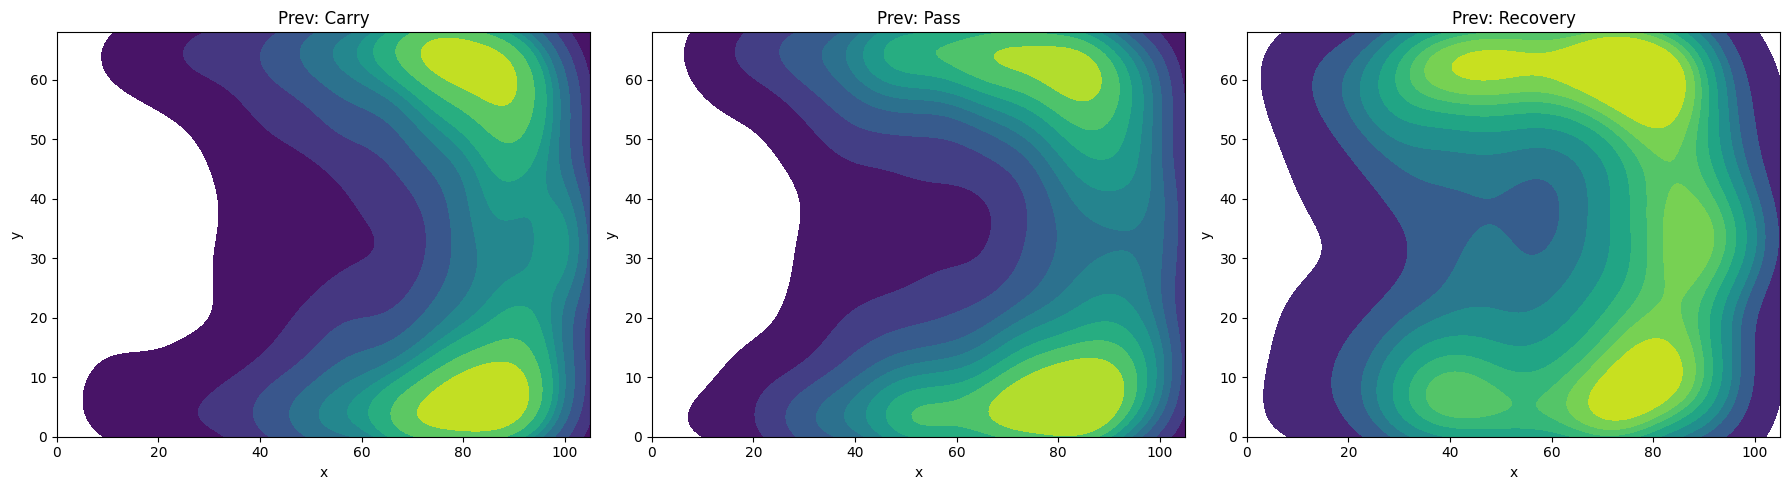

    Carry 직후 히트맵을 보면, x가 앞쪽(70~105)으로 강하게 집중되었음
    Pass 직후 히트맵은 carry보다 전반적으로 균형 잡혀 있음

In [ ]:
df_group = df_fp.groupby("prev_event")[["x", "y"]].mean().sort_values("x", ascending=False)

print(df_group)



```
                       x          y
prev_event                         
Carry          71.849914  33.354625
Tackle         71.600737  36.501270
Pass           67.280830  33.285676
Recovery       60.154429  34.738731
Interception   52.481026  35.844330
```



In [ ]:
df_fp["distance"] = np.sqrt(df_fp["x"]**2 + df_fp["y"]**2)
df_fp["angle"] = np.arctan2(df_fp["y"], df_fp["x"])

print(df_fp.groupby("prev_event")[["distance", "angle"]].mean())



```
                 distance     angle
prev_event      
Tackle          84.220635  0.463009                   
Carry           83.065326  0.429040
Pass            79.422205  0.450326
Recovery        73.658173  0.527489
Interception    67.969262  0.593078
```



    Carry와 Tackle 직후 패스가 가장 멀리 간다.

| prev_event       | x(center) | distance | angle   | 전술적 의미       |
| ---------------- | --------- | -------- | ------- | ------------ |
| **Carry**        | 가장 전방     | 길다       | 가장 직진   | 드리블-전진-침투패턴  |
| **Tackle**       | 전방        | 길다       | 직진      | 공 탈취 후 빠른 전진 |
| **Pass**         | 중전방       | 중간       | 약간 직진   | 빌드업 패스의 연결   |
| **Recovery**     | 중간        | 짧음       | 각도 큼    | 전환 공격, 측면 열기 |
| **Interception** | 후방        | 가장 짧음    | 가장 각도 큼 | 끊고 측면 벌리기    |


## 6.7 좌표 기반으로 EDA

In [ ]:
movement_records = []

for ge, g in train_df.groupby("game_episode"):
    g = g.sort_values(["time_seconds", "action_id"])
    xs = g["start_x"].values
    ys = g["start_y"].values
    types = g["type_name"].values

    for i in range(1, len(g)):
        dx = xs[i] - xs[i-1]
        dy = ys[i] - ys[i-1]
        distance = np.sqrt(dx*dx + dy*dy)
        angle = np.arctan2(dy, dx)  # -π ~ π

        movement_records.append([
            types[i],
            dx, dy, distance, angle
        ])

df_mv = pd.DataFrame(movement_records, columns=["event_type", "dx", "dy", "distance", "angle"])

In [ ]:
df_mv[["dx","dy","distance"]].describe().round(2)



```
데이터는 중앙–좌우 폭 사용이 고르게 분포
몇몇 이벤트는 경기장 전체를 가로지르는 이동으로 기록 (105가 전체 폭인데, min, max 값이 105에 가까움)

distance max가 125m인 것도, 대각선 길이가 125m 정도이기에, 완전한 반대편으로 보내는 롱패스나 클리어런스가 존재
```



In [ ]:
major = ["Carry", "Pass", "Recovery"]

plt.figure(figsize=(12, 4))

for i, evt in enumerate(major):
    plt.subplot(1, 3, i+1)
    sns.histplot(df_mv[df_mv["event_type"]==evt]["angle"], bins=40, kde=True)
    plt.title(f"Angle dist: {evt}")

plt.tight_layout()
plt.show()

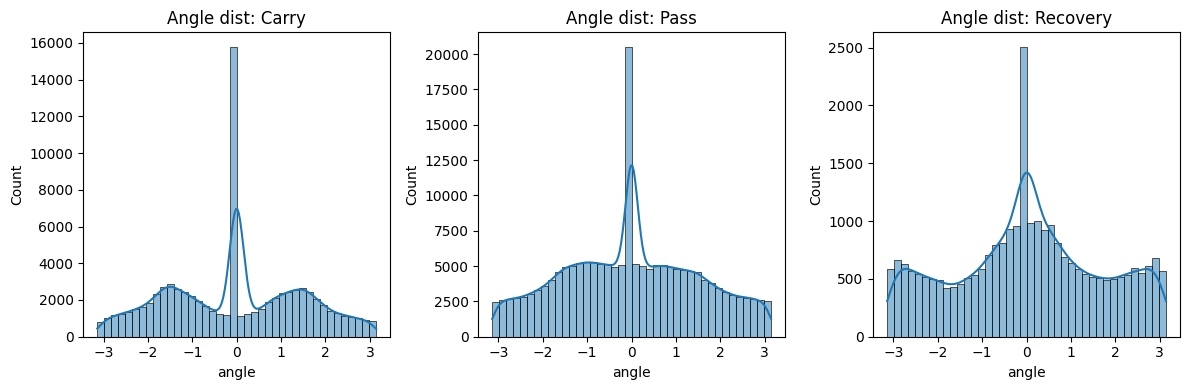

    Carry는 공이 어디로 움직였는지가 가장 중요한 단서가 되는 이벤트(movement-driven event)
    예를 들어, 공을 오른쪽으로 10m 드리블하면, 그 다음 패스가 오른쪽 아니면 앞쪽으로 나갈 가능성이 매우 높다는 뜻 !!
    즉, Carry 직후 행동은 이전 movement를 거의 ‘그대로 이어 받는다’는 뜻

    Pass 뒤에는 ‘방향성’이 약하기 때문에 주변 상황이 무엇인지가 더 중요(context-dependent event)
    그렇기에 모델에서 sequence attention이 매우 중요해지는 유형
    movement(이동 방향) 하나로는 다음 행동을 예측하기 어렵고, 이전에 어떤 이벤트들이 있었는지(맥락)가 더 중요

    Recovery 뒤에는 다음 행동이 워낙 다양해서 패턴이 하나로 정해져 있지 않음
    Recovery는 high-entropy movement event(불확실성이 높은 이벤트)


## 6.8 Episode 패턴 분류

---

    Episode 내부 이벤트와 좌표들을 기반으로
    Build-up / Carry-driven / Transition / Wide-switching / Chaotic / Long-pass dominance와 같은
    패턴을 자동으로 뽑아보고자 한다 !

    Episode 하나가 어떤 전개 형태인지 모델에 넣기 전에 라벨링!

---

    Episode = sequence
    Sequence를 요약할 대표 벡터를 만들고 클러스터링(k-means 등)으로 자연스럽게 Episode 패턴을 분류하는 방식으로 진행

▸ 요약 벡터 후보

| Feature           | 설명                                  |
| ----------------- | ----------------------------------- |
| event_ratio_pass  | Pass 비중                             |
| event_ratio_carry | Carry 비중                            |
| dx_mean / dy_mean | 평균 이동 방향                            |
| angle_std         | 방향성 변화(안정 vs 흔들림)                   |
| dist_mean         | 평균 이동 거리                            |
| turnover_flag     | episode 시작이 Recovery/Interception인지 |
| wide_switch_flag  | angle > 60° 이상 패스 비율                |

    위 벡터 정보를 episode별로 계산하고, matrix로 만든 뒤, 클러스터링

In [ ]:
def extract_episode_features(df):
    episode_features = []

    for ge, g in df.groupby("game_episode"):
        g = g.sort_values(["time_seconds", "action_id"]).reset_index(drop=True)

        types = g["type_name"].values
        xs, ys = g["start_x"].values, g["start_y"].values

        # 이동량 계산
        dx = np.diff(xs)
        dy = np.diff(ys)
        distance = np.sqrt(dx*dx + dy*dy)
        angle = np.arctan2(dy, dx)

        # Episode-level summary
        feat = {
            "game_episode": ge,
            "len": len(g),
            "ratio_pass": np.mean(types == "Pass"),
            "ratio_carry": np.mean(types == "Carry"),
            "dx_mean": np.mean(dx) if len(dx) > 0 else 0,
            "dy_mean": np.mean(dy) if len(dy) > 0 else 0,
            "angle_mean": np.mean(angle) if len(angle) > 0 else 0,
            "angle_std": np.std(angle) if len(angle) > 0 else 0,
            "dist_mean": np.mean(distance) if len(distance) > 0 else 0,
            "dist_cum": np.sum(distance) if len(distance) > 0 else 0,
            # "turnover_flag": int(types[0] in ["Recovery", "Interception", "Tackle"]),
            # "wide_switch_flag": int(np.mean(np.abs(angle) > np.deg2rad(60)) > 0.3),
        }

        episode_features.append(feat)

    return pd.DataFrame(episode_features)

epi_feat = extract_episode_features(train_df)
epi_feat.head()

In [ ]:
epi_feat.describe().round(2)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

use_cols = ["len", "ratio_pass", "ratio_carry", "dx_mean", "dy_mean", "angle_mean", "angle_std", "dist_mean", "dist_cum"]

X = epi_feat[use_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)

epi_feat["cluster"] = kmeans.fit_predict(X_scaled)

epi_feat["cluster"].value_counts()

In [ ]:
cluster_summary = epi_feat.groupby("cluster")[use_cols].mean().round(3)
print(cluster_summary)

| cluster | len      | ratio_pass | ratio_carry | dx_mean | dy_mean    | angle_mean | angle_std | dist_mean | dist_cum |
| ------- | -------- | ---------- | ----------- | ------- | ---------- | ---------- | --------- | --------- | -------- |
| **0**   | 18.9     | 0.565      | 0.235       | 0.58    | -0.006     | -0.025     | 1.543     | 15.65     | 291      |
| **1**   | 3.96     | 0.482      | 0.106       | 5.21    | **9.448**  | 1.031      | **0.49**  | 16.92     | 49.3     |
| **2**   | 14.8     | 0.329      | 0.147       | -0.588  | 0.305      | 0.008      | 1.393     | **26.12** | 340.6    |
| **3**   | 4.2      | 0.465      | 0.131       | 3.619   | **-9.428** | -1.144     | **0.54**  | 16.26     | 51.9     |
| **4**   | **62.8** | 0.501      | 0.242       | 0.193   | 0.000      | -0.019     | 1.555     | 18.96     | **1153** |


In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, kmeans.labels_)
score



```
실루엣 스코어도 0.224 정도로 전술 클러스터링에서는 괜찮은 수준

Cluster 0: 균형 잡힌 패스 기반 전개
- ratio_pass = 0.565 → 패스 중심
- ratio_carry = 0.235 → 적당한 드리블 활용
- dx_mean ≈ 0.58 → 가벼운 전진 성향
- 수비–중간–공격 연결 과정에서 자주 나타나는 형태

Cluster 1: 짧은 측면 전개
- len ≈ 4 → 매우 짧음
- dy_mean = +9.45 → 강한 위쪽(혹은 오른쪽) 측면 진행
- dx_mean = +5.21 → 약간 전진
- angle_std = 매우 낮음 → “한 방향으로 쭉 이동”
- 터치라인 근처에서 빠르게 전개하다가 끊기는 짧은 sequence

Cluster 2: 후방 리셋 또는 긴 거리 후퇴/재전개
- ratio_pass = 0.329 → 패스보다 비패스 이벤트가 많음
- dx_mean = -0.588 → 후퇴 성향
- dist_mean = 26.12 → 한 번의 이동이 매우 큼
- dist_cum = 340 이상
- 후방 리셋(reset), 또는 압박에서 벗어나기 위한 후방–측면 방향의 큰 움직임

Cluster 3: 짧은 반대 측면 전환
- len ≈ 4 → 매우 짧음
- dy_mean = -9.43 → Cluster 1과 반대 방향
- Cluster 1과 완전히 대칭되는 “짧은 측면 전환 흐름”
- 압박을 피하려고 측면에서 반대측면으로 짧게 돌리는 패턴

Cluster 4: 긴 연속 빌드업
- dist_cum 1153 → 전체 이동량 매우 큼
- dist_mean ≈ 19
- 장시간 점유 기반의 빌드업/공격 전개 전체 흐름
```

| Cluster | 전술 패턴 이름                     | 의미                    |
| ------- | ---------------------------- | --------------------- |
| **0**   | Balanced Build-up            | 안정적 패스·드리블 혼합 빌드업     |
| **1**   | Short Left/Right Wide Play   | 한 방향으로 직선적이고 짧은 측면 전개 |
| **2**   | Reset / Backward Large Shift | 후방 리셋 또는 큰 폭의 방향 변경   |
| **3**   | Short Opposite Wide Switch   | 반대 방향으로 단시간 측면 전환     |
| **4**   | Long Build-up Sequence       | 긴 점유 기반 전체 빌드업 흐름     |


### 6.8.1 각 패턴별 Final Pass 평균 위치 확인과 Heatmap으로 분석

In [ ]:
# 마지막 이벤트의 end 좌표 추출
last_events = train_df.groupby("game_episode").tail(1)[["game_episode", "end_x", "end_y"]]

# cluster 정보와 결합
merged = epi_feat.merge(last_events, on="game_episode")
merged.head()

# 7. Feature Engineering

---

▸ 패스 각도(angle)

    angle = arctan((end_y-start_y) / (end_x-start_x))

    풀백은 측면으로 많이 주고, 중앙 미드필더는 전진 패스의 비율 높음
    수비수는 옆으로 주는 패스나 후방 패스의 비중 높음

▸ 패스 진행 거리

    더 먼 패스일수록 progressive chance가 높고, end_x가 강하게 증가하는 패턴을 가짐

▸ event_type 임베딩

    type_name → embedding vector
    result_name → embedding vector

    sequence embedding에 필수적으로 진행해야하는 것

▸ 에피소드에서의 속도(Δx, Δy)

    dx_t = x_t - x_(t-1)
    dy_t = y_t - y_(t-1)

    엔드 투 엔드 모델보다 훨씬 패턴 학습이 잘 됨

    dx > 0 → 오른쪽으로 전진 중
    dy > 0 → 위쪽으로 이동 중
    dy < 0 → 아래쪽으로 이동 중
    dx ≈ 0 → 횡패스 빈도 높음
    dx < 0 → 후방 패스 비율 증가 (안정화)

    1. 한 에피소드에서 dx가 계속 증가한다 ➜ 공격 전개 중 (전진 패스 가능성이 높음)
    2. dy가 크게 증가했다➜ 측면 전개 중 (사이드로 패스가 날아갈 가능성)
    3. dx가 음수로 전환되었다 ➜ 후방 안정화 패스 패턴
    4. dx, dy가 급격히 바뀐다 ➜ 압박을 벗어나기 위한 빠른 전개